# Task 3

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

/Users/zybell/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
NPI = pd.read_table('Medicare_Physician_and_Other_Supplier_NPI_Aggregate_CY2014.txt')

/Users/zybell/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Make a new dataframe with only nppes_entitiy_code equals 'I'
NPI_ind = NPI[(NPI['nppes_entity_code']=='I')]

In [4]:
NPI_ind['provider_type'].value_counts()

Internal Medicine                          97477
Family Practice                            82256
Nurse Practitioner                         73815
Physician Assistant                        54657
Physical Therapist                         41290
Emergency Medicine                         40433
CRNA                                       39100
Anesthesiology                             36947
Chiropractic                               36533
Diagnostic Radiology                       29384
Optometry                                  28468
Obstetrics/Gynecology                      27647
Cardiology                                 22884
Psychiatry                                 22609
Orthopedic Surgery                         21301
General Surgery                            19905
Ophthalmology                              17664
Licensed Clinical Social Worker            16497
Podiatry                                   14949
Clinical Psychologist                      14650
Neurology           

In [5]:
# Add a new column called "pcp" with 1 or 0
def pcp(df):
  if df['provider_type'] in ["Internal Medicine","Family Practice"]:
    return 1
  else:
    return 0

NPI_ind['pcp'] = NPI_ind.apply(pcp, axis=1)

/Users/zybell/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# Check if the 1 and 0 classes are balanced
NPI_ind['pcp'].value_counts()

0    745614
1    179733
Name: pcp, dtype: int64

In [7]:
NPI_ind.shape

(925347, 71)

In [8]:
# Deal with missing data, eg NaN of infinite values
# Drop rows where all cells in that row is NA
NPI_cleaned = NPI_ind.dropna(how='all')
# Drop rows that contain less than 60 observations out of 71
NPI_cleaned = NPI_cleaned.dropna(thresh=60)

In [9]:
NPI_cleaned.shape

(460380, 71)

In [10]:
# Now drop columns 
# Drop columns that contains more than around 10000 of missing values
NPI_cleaned = NPI_cleaned.dropna(axis=1, thresh=450000)

In [11]:
NPI_cleaned.shape

(460380, 50)

In [12]:
NPI_cleaned['nppes_provider_city'].describe()
# Too many unique cities, 8850 in the list, need to drop 'nppes_provider_city'

count       460380
unique        8850
top       NEW YORK
freq          5924
Name: nppes_provider_city, dtype: object

In [13]:
NPI_cleaned['nppes_provider_state'].describe()
# Only 59 unique states, worth making dummy variables,keep

count     460380
unique        59
top           CA
freq       36171
Name: nppes_provider_state, dtype: object

In [14]:
NPI_cleaned ['nppes_provider_country'].describe()
# Only 24 unique countries, but mostly in US, not worth keeping the variable in the prediction model
#drop 'nppes_provider_country'

count     460380
unique        17
top           US
freq      460345
Name: nppes_provider_country, dtype: object

In [15]:
NPI_cleaned['medicare_participation_indicator'].describe()

count     460380
unique         2
top            Y
freq      460378
Name: medicare_participation_indicator, dtype: object

In [16]:
NPI_cleaned = NPI_cleaned.drop(['nppes_provider_city', 'nppes_provider_country'], axis=1) 

In [17]:
NPI_cleaned['pcp'].value_counts()

0    348341
1    112039
Name: pcp, dtype: int64

In [18]:
# Drop uninformative columns that won't help with prediction
NPI_ind_model = NPI_cleaned.drop(['npi', 'nppes_provider_last_org_name',\
                                  'nppes_provider_first_name',\
                                  'nppes_entity_code',\
                                  'nppes_provider_street1',\
                                  'nppes_provider_zip'], axis=1)

In [19]:
NPI_ind_model_d = NPI_ind_model.dropna()

In [20]:
NPI_ind_model_d.count()

nppes_provider_gender               444684
nppes_provider_state                444684
provider_type                       444684
medicare_participation_indicator    444684
number_of_hcpcs                     444684
total_services                      444684
total_unique_benes                  444684
total_submitted_chrg_amt            444684
total_medicare_allowed_amt          444684
total_medicare_payment_amt          444684
total_medicare_stnd_amt             444684
number_of_drug_hcpcs                444684
total_drug_services                 444684
total_drug_unique_benes             444684
total_drug_submitted_chrg_amt       444684
total_drug_medicare_allowed_amt     444684
total_drug_medicare_payment_amt     444684
total_drug_medicare_stnd_amt        444684
number_of_med_hcpcs                 444684
total_med_services                  444684
total_med_unique_benes              444684
total_med_submitted_chrg_amt        444684
total_med_medicare_allowed_amt      444684
total_med_m

In [21]:
NPI_ind_model_d.head()

,nppes_provider_gender,nppes_provider_state,provider_type,medicare_participation_indicator,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,...,beneficiary_cc_ckd_percent,beneficiary_cc_copd_percent,beneficiary_cc_depr_percent,beneficiary_cc_diab_percent,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_raoa_percent,Beneficiary_Average_Risk_Score,pcp
0,M,MD,Internal Medicine,Y,16,2749.0,913,750652.00,254849.52,194073.09,...,56.0,43.0,46.0,52.0,70.0,75.0,68.0,53.0,2.2206,1
1,M,IL,Pathology,Y,13,8643.0,4276,1357139.00,321641.88,245364.34,...,14.0,7.0,12.0,20.0,53.0,57.0,28.0,37.0,1.0007,0
3,M,PA,Family Practice,Y,39,1012.0,392,169486.00,110286.91,85665.04,...,43.0,38.0,47.0,40.0,59.0,75.0,62.0,45.0,1.7228,1
5,M,CO,General Surgery,Y,62,238.0,153,317428.25,61302.67,47097.18,...,44.0,12.0,39.0,36.0,37.0,69.0,27.0,39.0,2.1111,0
7,F,PA,Internal Medicine,Y,32,848.0,302,90588.00,60650.83,41392.10,...,17.0,12.0,21.0,22.0,60.0,65.0,26.0,27.0,0.9057,1


In [22]:
y = NPI_ind_model_d['pcp']

In [23]:
NPI_ind_model_d_X = NPI_ind_model_d.drop(['provider_type'], axis=1)

In [24]:
X_matrix = NPI_ind_model_d_X.drop(['pcp'], axis = 1)

df_state = pd.get_dummies(NPI_ind_model_d['nppes_provider_state'])

# Make dummy variables
NPI_ind_model_d = pd.concat([NPI_ind_model_d, df_state], axis=1)
NPI_ind_model_d.drop(['nppes_provider_state'], axis=1, inplace=True)

In [25]:
X_matrix = pd.get_dummies(X_matrix)

In [26]:
X_matrix.columns

Index([u'number_of_hcpcs', u'total_services', u'total_unique_benes',
       u'total_submitted_chrg_amt', u'total_medicare_allowed_amt',
       u'total_medicare_payment_amt', u'total_medicare_stnd_amt',
       u'number_of_drug_hcpcs', u'total_drug_services',
       u'total_drug_unique_benes', u'total_drug_submitted_chrg_amt',
       u'total_drug_medicare_allowed_amt', u'total_drug_medicare_payment_amt',
       u'total_drug_medicare_stnd_amt', u'number_of_med_hcpcs',
       u'total_med_services', u'total_med_unique_benes',
       u'total_med_submitted_chrg_amt', u'total_med_medicare_allowed_amt',
       u'total_med_medicare_payment_amt', u'total_med_medicare_stnd_amt',
       u'beneficiary_average_age', u'beneficiary_age_65_74_count',
       u'beneficiary_female_count', u'beneficiary_male_count',
       u'beneficiary_nondual_count', u'beneficiary_dual_count',
       u'beneficiary_cc_chf_percent', u'beneficiary_cc_ckd_percent',
       u'beneficiary_cc_copd_percent', u'beneficiary_cc_depr_

In [27]:
# Split train, test set
# Aim to set aside 30% data as test set, and 70% as train_valid set

from sklearn.cross_validation import train_test_split
X_tr_va, X_test, y_tr_va, y_test = train_test_split(X_matrix, y, test_size=0.3)

In [28]:
X_tr_va.dtypes

number_of_hcpcs                         int64
total_services                        float64
total_unique_benes                      int64
total_submitted_chrg_amt              float64
total_medicare_allowed_amt            float64
total_medicare_payment_amt            float64
total_medicare_stnd_amt               float64
number_of_drug_hcpcs                  float64
total_drug_services                   float64
total_drug_unique_benes               float64
total_drug_submitted_chrg_amt         float64
total_drug_medicare_allowed_amt       float64
total_drug_medicare_payment_amt       float64
total_drug_medicare_stnd_amt          float64
number_of_med_hcpcs                   float64
total_med_services                    float64
total_med_unique_benes                float64
total_med_submitted_chrg_amt          float64
total_med_medicare_allowed_amt        float64
total_med_medicare_payment_amt        float64
total_med_medicare_stnd_amt           float64
beneficiary_average_age           

In [29]:
X_matrix.describe()

,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,total_medicare_stnd_amt,number_of_drug_hcpcs,total_drug_services,total_drug_unique_benes,...,nppes_provider_state_VA,nppes_provider_state_VI,nppes_provider_state_VT,nppes_provider_state_WA,nppes_provider_state_WI,nppes_provider_state_WV,nppes_provider_state_WY,nppes_provider_state_ZZ,medicare_participation_indicator_N,medicare_participation_indicator_Y
count,444684.000000,4.446840e+05,444684.000000,4.446840e+05,4.446840e+05,4.446840e+05,4.446840e+05,444684.000000,4.446840e+05,444684.000000,...,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000,444684.000000
mean,48.537978,3.792676e+03,562.612808,4.843069e+05,1.782208e+05,1.349512e+05,1.345689e+05,2.855560,1.803580e+03,36.689634,...,0.026734,0.000056,0.002163,0.018867,0.018723,0.006976,0.001441,0.000079,0.000002,0.999998
std,40.488247,1.726368e+04,689.262935,8.421349e+05,3.264740e+05,2.525901e+05,2.500769e+05,7.250413,1.610795e+04,83.011842,...,0.161304,0.007498,0.046461,0.136057,0.135547,0.083229,0.037939,0.008871,0.001500,0.001500
min,1.000000,4.000000e+01,32.000000,7.970800e+02,5.749600e+02,4.856600e+02,4.506600e+02,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,5.080000e+02,226.000000,1.378555e+05,4.987731e+04,3.720607e+04,3.797089e+04,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,37.000000,1.160000e+03,363.000000,2.699758e+05,9.795147e+04,7.332896e+04,7.369515e+04,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,63.000000,2.839000e+03,616.000000,5.292202e+05,1.904517e+05,1.430553e+05,1.431590e+05,3.000000,1.090000e+02,38.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,619.000000,3.452292e+06,55886.000000,4.156214e+07,1.894713e+07,1.480165e+07,1.520900e+07,119.000000,3.443171e+06,10835.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# Since the X matrix has a mixture of both categorical and continous variables
# Due to missing data, and dummy variable generation, the dataset is sparse
# I decided to use Random Forest, the tree ensemble method to do the preliminary model training

# Start with a less complicated RF to explore the data
rf_model = RandomForestClassifier(max_depth=None, n_estimators=10, max_features= 1,\
                            min_samples_split=100,min_samples_leaf = 10000, bootstrap=False, criterion='gini') 
RF_try = rf_model.fit(X_tr_va, y_tr_va) #model fitting

In [31]:
# Use cross-validation to look at the RF_try model's consistency
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

cv = cross_validation.ShuffleSplit(len(y_tr_va), n_iter=5,test_size=0.2) # 5 inter of cv

In [32]:
scores_RF_try = cross_validation.cross_val_score(RF_try, X_tr_va, y_tr_va, cv=cv)

auc_score = roc_auc_score(y_test, RF_try.predict_proba(X_test)[:,1])

acc = accuracy_score(y_test, RF_try.predict(X_test))
f1 = f1_score(y_test, RF_try.predict(X_test),average='weighted')

print "score_mean = ", scores_RF_try.mean(), 
print "score_std = ", scores_RF_try.std(),
print "roc_auc_score = ", auc_score
print "acc = ", acc
print "f1 = ", f1

score_mean =  0.759714726291 score_std =  0.000697750463349 roc_auc_score =  0.720271947696
acc =  0.759913347226
f1 =  0.6562462819


/Users/zybell/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
## Play with parameters

# max_depth = None
# n_estimator = 100
# min_samples_leaf = 1000
# Bootstrap = False

rf_model_2 = RandomForestClassifier(max_depth=None, n_estimators=100,\
                            min_samples_split=100,min_samples_leaf = 1000, bootstrap=False,criterion='gini') 
RF_try_2 = rf_model_2.fit(X_tr_va, y_tr_va) #model fitting


scores_RF_try = cross_validation.cross_val_score(RF_try_2, X_tr_va, y_tr_va, cv=cv)
auc_score = roc_auc_score(y_test, RF_try_2.predict_proba(X_test)[:,1])
acc = accuracy_score(y_test, RF_try_2.predict(X_test))
f1 = f1_score(y_test, RF_try_2.predict(X_test),average='weighted')

print "score_mean = ", scores_RF_try.mean(), 
print "score_std = ", scores_RF_try.std()
print "roc_auc_score = ", auc_score
print "acc = ", acc
print "f1 = ", f1

score_mean =  0.872616294012 score_std =  0.00138916338506
roc_auc_score =  0.921255022699
acc =  0.876594755858
f1 =  0.868546090103


Tree performance greatly improved with test set.
Now try Bootstrap = True

In [34]:
# max_depth = None
# n_estimator = 150
# min_samples_leaf = 1000
# bootstrap = True

rf_model_3 = RandomForestClassifier(max_depth=None, n_estimators=150,\
                            min_samples_split=100,min_samples_leaf = 1000, bootstrap=True,criterion='gini') 
RF_try_3 = rf_model_3.fit(X_tr_va, y_tr_va) #model fitting


scores_RF_try = cross_validation.cross_val_score(RF_try_3, X_tr_va, y_tr_va, cv=cv)
auc_score = roc_auc_score(y_test, RF_try_3.predict_proba(X_test)[:,1])
acc = accuracy_score(y_test, RF_try_3.predict(X_test))
f1 = f1_score(y_test, RF_try_3.predict(X_test),average='weighted')

print "score_mean = ", scores_RF_try.mean(), 
print "score_std = ", scores_RF_try.std()
print "roc_auc_score = ", auc_score
print "acc = ", acc
print "f1 = ", f1

score_mean =  0.868199049088 score_std =  0.000695320508716
roc_auc_score =  0.914638454181
acc =  0.868791508628
f1 =  0.858788975557


In [35]:
# To tune the hyper-parameters of an estimator, we can either use grid search or randomized parameter optimization.
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'auto' ,n_estimators=150, oob_score = True,\
                            min_samples_split=100,min_samples_leaf = 1000, bootstrap=True,criterion='gini') 

param_grid = {
    'n_estimators': [100,150,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [50,100,150],
    'min_samples_leaf': [500,1000,5000,10000]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_tr_va, y_tr_va)
print CV_rfc.best_params_

/Users/zybell/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'max_features': 'sqrt', 'min_samples_split': 150, 'n_estimators': 150, 'min_samples_leaf': 500}


In [36]:
# Build the final Random Forest model with hyperparameters from the grid search result:
rf_final_model = RandomForestClassifier(max_features= 'auto', n_estimators=200,\
                                        oob_score = True, max_depth=None, min_samples_split=50,\
                                        min_samples_leaf = 500, bootstrap=True,criterion='gini') 
RF_final = rf_final_model.fit(X_tr_va, y_tr_va)

In [37]:
scores_RF_final = cross_validation.cross_val_score(RF_final, X_tr_va, y_tr_va, cv=cv)
auc_score = roc_auc_score(y_test, RF_final.predict_proba(X_test)[:,1])
acc = accuracy_score(y_test, RF_final.predict(X_test))
f1 = f1_score(y_test, RF_final.predict(X_test),average='weighted')

print "score_mean = ", scores_RF_final.mean(), 
print "score_std = ", scores_RF_final.std()
print "roc_auc_score = ", auc_score
print "acc = ", acc
print "f1 = ", f1

score_mean =  0.877390131072 score_std =  0.00120854779308
roc_auc_score =  0.924492158599
acc =  0.880200290841
f1 =  0.872828947458


With the final trained Random Forest model, I made prediction on the held out "test" dataset, and the AUC is 0.92 for this held out set

In [38]:
# Calculate fpr, tpr and thresholds on the test set for the final Random Forest model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, RF_final.predict_proba(X_test)[:,1])

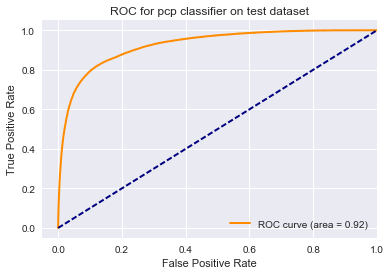

In [39]:
# Visualize ROC curve on the test set
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for pcp classifier on test dataset')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Look at feature importance and see which variables in X are the best indicators for pcp classification
importance = rf_final_model.feature_importances_
importance = pd.DataFrame(importance, index=X_matrix.columns, 
                          columns=["Importance"])

In [41]:
importance.sort_values(['Importance'], ascending = [0]).head(5)

,Importance
number_of_drug_hcpcs,0.119924
total_drug_unique_benes,0.063840
total_drug_medicare_stnd_amt,0.057714
beneficiary_cc_ckd_percent,0.056593
total_drug_medicare_allowed_amt,0.054353


The top 5 most important features to predict pcp are:
(1)'number_of_drug_hcpcs', 
(2)'beneficiary_cc_ckd_percent',
(3)'total_drug_medicare_payment_amt', 
(4)'total_drug_unique_benes',
(5)'total_drug_submitted_chrg_amt'